# In this notebook I will try to clean up the basic lane detection functions and then improve them with the ideas from the advanced lane detection

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
import numpy as np
import cv2

In [50]:
filepath = 'road_image2.jpeg'

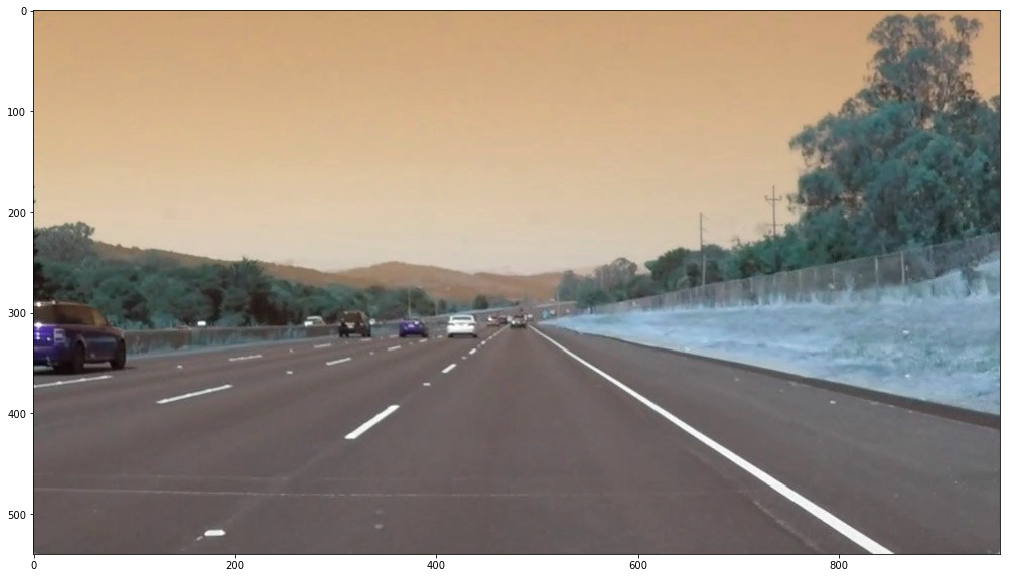

In [51]:
image = cv2.imread(filepath)
plt.imshow(image)

In [52]:
def mask_image(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    lower_yellow = np.array([20, 100, 100], dtype = 'uint8')
    upper_yellow = np.array([30, 255, 255], dtype='uint8')
    mask_yellow = cv2.inRange(image_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(image_gray, 150, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)
    return cv2.bitwise_and(image_gray, mask_yw)

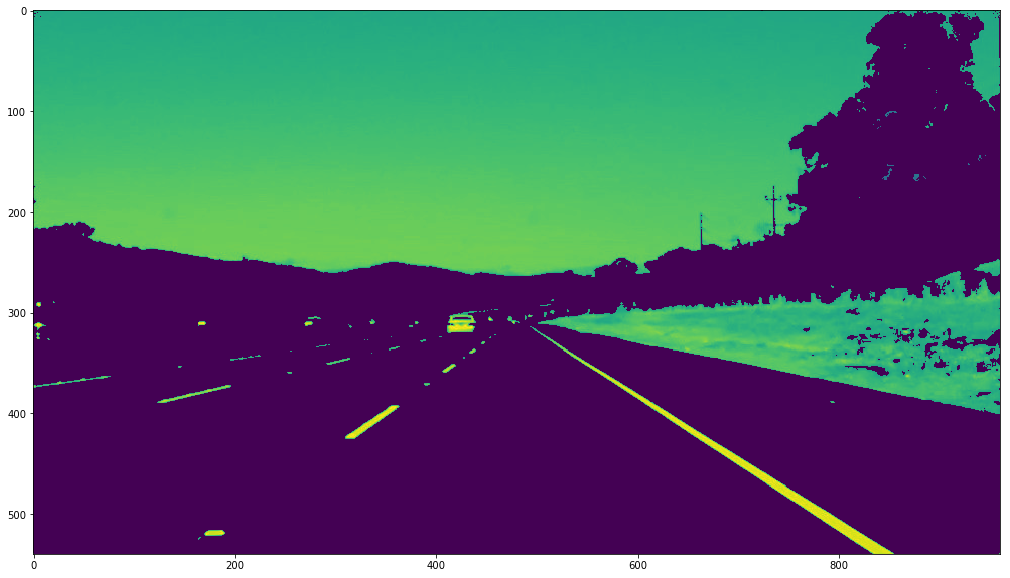

In [53]:
plt.imshow(mask_image(image))

In [54]:
def edge_detection(image, blur_kernel_size=5, low_threshold=50, high_threshold=150):
    blurred_image = cv2.GaussianBlur(image, (blur_kernel_size, blur_kernel_size), 0)
    edges_image = cv2.Canny(blurred_image, low_threshold, high_threshold)
    return edges_image

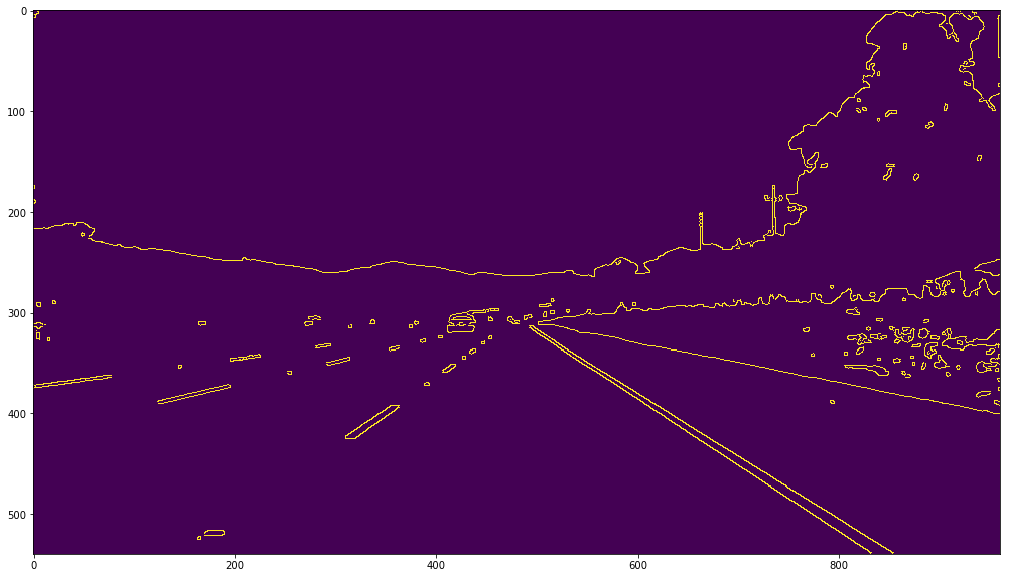

In [55]:
plt.imshow(edge_detection(mask_image(image)))

In [56]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)

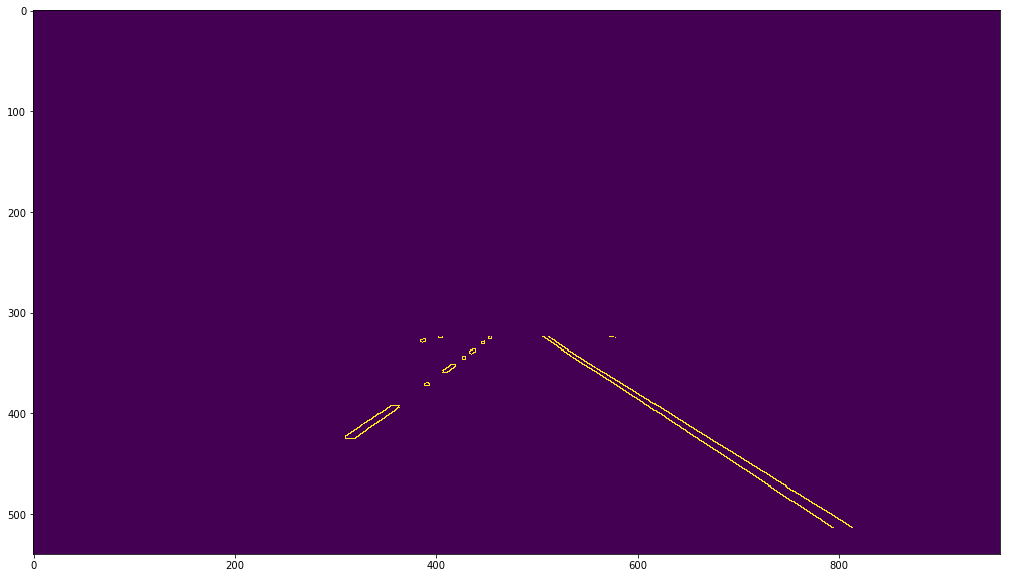

In [57]:
plt.imshow(select_region(edge_detection(mask_image(image))))

In [58]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [59]:
def show_hough_lines(lines, image):
    image_hough = np.zeros_like(image)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_hough,(x1,y1),(x2,y2),255,2)
    plt.imshow(image_hough)

In [60]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

In [61]:
def lane_lines(image, lines):
    
    
    return left_line, right_line

In [62]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

In [63]:
def estimate_lane_lines(image,
                        show_hough=False,
                        h_rho=1,
                        h_theta=np.pi/180,
                        h_threshold=5,
                        h_minLineLength=2,
                        h_maxLineGap=300):
    lines = cv2.HoughLinesP(image, 
                        rho=h_rho,
                        theta=h_theta, 
                        threshold=h_threshold, 
                        minLineLength=h_minLineLength, 
                        maxLineGap=h_maxLineGap)
    if lines is None:
        print('No lines detected')
        return None, None, None
    if show_hough:
        show_hough_lines(lines, image)
    
    s_i_lanes = average_slope_intercept(lines)
    
    left_lane, right_lane = average_slope_intercept(lines)
    # Extend the lines
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle
    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return s_i_lanes, left_line, right_line

In [64]:
estimate_lane_lines(select_region(edge_detection(mask_image(image))),
                   show_hough=False)

((array([  -0.72497212,  651.6667998 ]), array([ 0.65235369, -3.09182303])),
 ((154, 540), (451, 324)),
 ((832, 540), (501, 324)))

In [65]:
s_i_lanes, \
left_lane, \
right_lane = estimate_lane_lines(select_region(edge_detection(mask_image(image))))

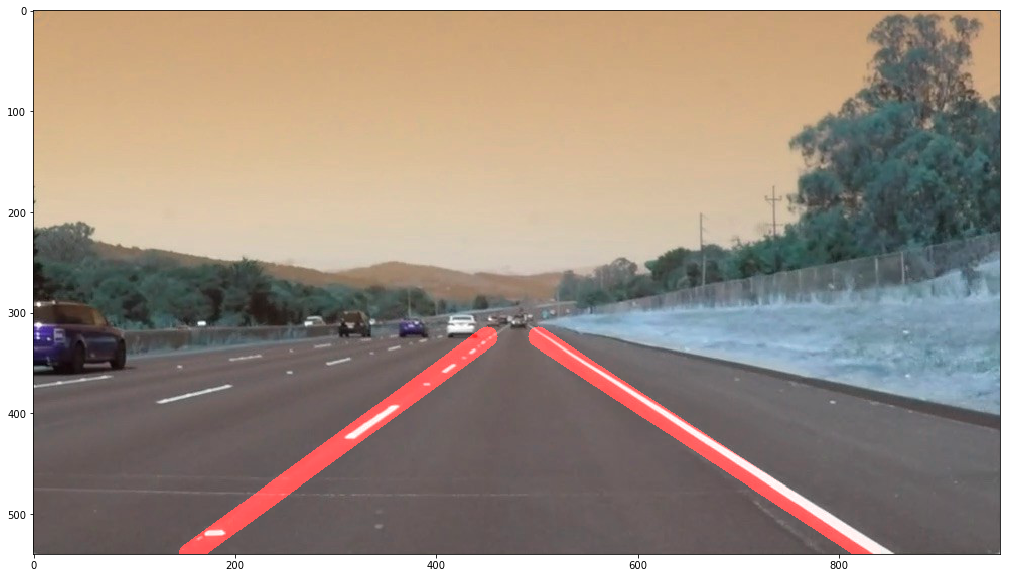

In [66]:
lane_image = draw_lane_lines(image, (left_lane, right_lane))
plt.imshow(lane_image)

In [67]:
def basic_lane_detection(image, show=True, show_hough=False):
    s_i_lanes, \
    left_lane, \
    right_lane = estimate_lane_lines(select_region(edge_detection(mask_image(image))),
                                    show_hough=show_hough)
    if s_i_lanes is None:
        return None, None, None
    if show:
        plt.imshow(draw_lane_lines(image, (left_lane, right_lane)))
    return s_i_lanes, left_lane, right_lane

((array([  -0.72497212,  651.6667998 ]), array([ 0.65235369, -3.09182303])),
 ((154, 540), (451, 324)),
 ((832, 540), (501, 324)))

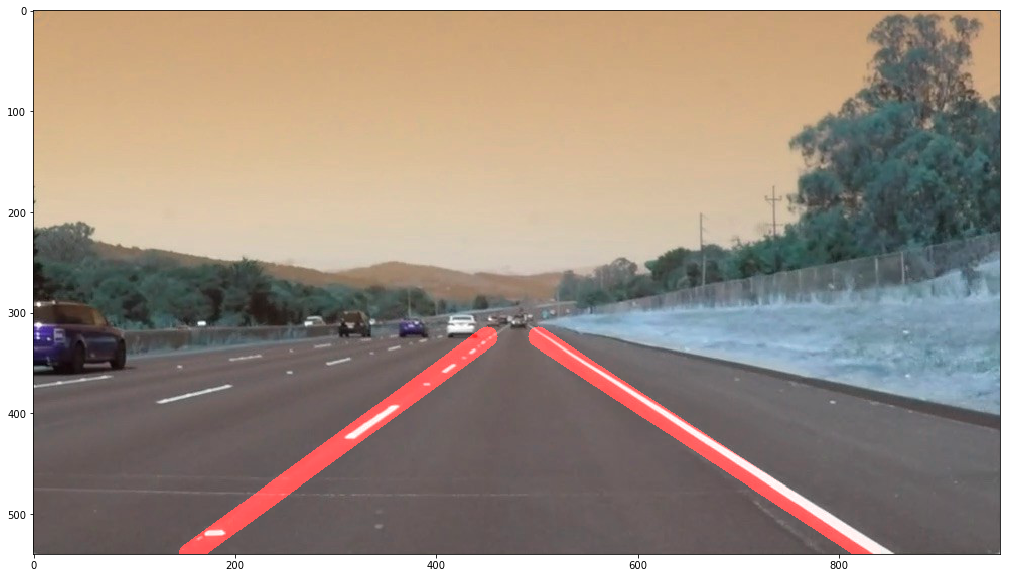

In [68]:
basic_lane_detection(image)

## Let's try the second image...

((array([ -7.79724161e-01,   9.04421591e+02]),
  array([   0.46716018,  156.62514074])),
 ((245, 713), (611, 427)),
 ((1190, 713), (580, 427)))

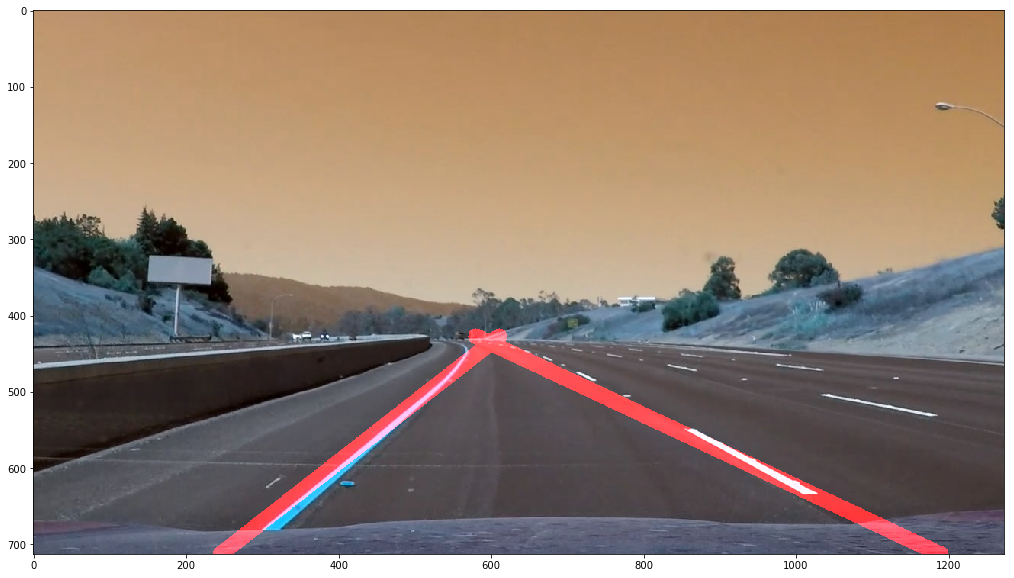

In [69]:
filepath = 'road_image.png'
image = cv2.imread(filepath)
basic_lane_detection(image)

## Let's try this with some simulator images

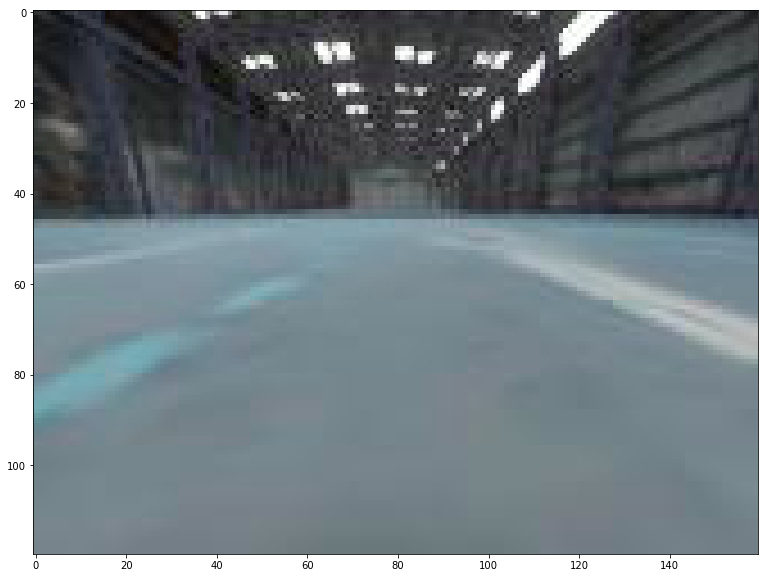

In [70]:
sim_image = cv2.imread('sim_image_0.jpg')
plt.imshow(sim_image)

In [71]:
basic_lane_detection(sim_image, show_hough=True)

No lines detected


(None, None, None)